<font size = '5'> <center> <u>**Tick tack toe using Reinforcement Learning**</u></center></font>

In this notebook, we will teach an agent to play tick tack toe using reinforcement learning. 

In [1]:
#first import all the libraries needed
from board import tick_tack_toe
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

First we will check the board out.

In [2]:
#initialize a game
game = tick_tack_toe()
game.print_board()

    |    |   
    |    |  
____|____|___
    |    |  
    |    |  
____|____|___
    |    |  
    |    |  
    |    |  


<u><font size = '3'> **Reinforcement Learning** </font></u>

The model will give values to the agent after each state. The state consist all the moves played by the agents. During training, agent 1 will be taught to play first and agent 2 second. In agent 1's memory we will store all the states that were rewarding to agent 1 and in agent 2's memory we will store all the states that were rewarding for agent 2. 

Agent 1 will be playing 'O' and agent 2 will be playing 'X'. An example of a state vector is below. 

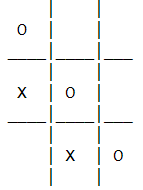

In the game above, agent 1 started first so the following state vector will be assigned to agent 1's memory with a reward of +1. 

state = [1, 4, 5, 8, 9]

since this is in player 1's memory the player knows that the moves he/she played was 1, 5, 9 against moves 4 and 8 by agent 2. And since agent 1 won the game this will be a rewarding state for agent 1 whereas for agent 2, this will be a bad state to visit again. So we will assign -1 for agent 2 for this game. If the game is a draw both agents will recieve 0 points. Furthermore we will give reward to the states that led to this final state accordingly with a discount rate (gamma). 

So if the first iteration had the game above, player 1 and player 2 will have the following states stored. 

- Player 1 - [1, 4, 5, 8, 9] with a value of +1, [1, 4, 5, 8] with some value (approx 0.8), [1, 4, 5] with some value ( appprox 0.6) and so on
- Player 2 - [1, 4, 5, 8, 9] with a value of -1, [1, 4, 5, 8] with some value (approx -0.8) and so on.

*Note that these values change based on the reward, learning_rate and  discount rate*

Now let's create some functions to select moves, store values etc.

<u>Selecting moves -</u> 

Each agent will select moves based on the values of the stored moves in each memory. If there is no games stored in the memory the agent will randomly select moves. The agent also want to explore so we will have the agent select random moves once in a while. 

In [3]:
#the first function will select moves. THis is the second attempt to make this correct. NEWWWWWW

def choose_move(avail_moves, current_state, states_and_values, epsilon = 0.1):
    """
    inputs
    -------
    avail_moves - moves that are available to choose from
    current_state - the current state vector of the game
    states_and_values - a dictionary containing all the past states and their values
    epsilon - the probability the algorithm will explore new moves default at 0.1
    
    output
    -------
    action - this function outputs the most rewarding move
    """    
    #exploration. choose 0 and 1 with a given probability. and explore if 0 is chosen
    explore = np.random.choice([0, 1], p = [epsilon, 1 - epsilon])
    
    if explore == 0:
        
        #randomly choose action
        action = np.random.choice(avail_moves)
    
    else:
        
        #max val
        max_val = -999
        
        #iterate through all the available moves
        for avail_move in avail_moves:

            #current state
            cs = current_state
            cs.append(avail_move) #add the available move to the current state
            
            #check if this move has already been played 
            if tuple(cs) in states_and_values.keys():
                
                #if the move is played get the value
                val = states_and_values[tuple(cs)]
            
            else:
                
                val = 0
                
            #check if its higher than the max val
            if val > max_val:

                #if it is higher we will choose that value for next action
                action = avail_move
                max_val = val
                    
            #remove this move from the list before moving on to the next iteration (next available move)
            cs.remove(avail_move)       
        
    return action

We'll run some hypothetical situations to see if the choose_move function is working properly. We will use two example situations and will run multiple iterations and plot the moves distributions. 

First we will create an example states_and_values dictionary. 

states_and_values = {(1): 0.1, (1, 5): 0.9, (2):5, (2, 3, 1): 7, (2, 3, 9): 4, (1, 6): 3} 

<u>**Scenario 1**</u>

current_state = [1]

avail_moves = [2, 3, 4, 5, 6, 7, 8, 9]

In this situation, the current state is 1 and the agent has played only one move. So now the agent has to play the second move. There are 2 states that start with 1 and the second move is already available, (1, 5) and (1, 6). If we check the values of these two moves (1, 5) has a value of 0.9 and (1, 6) has a value of 3. So the agent will choose move 6 in this case because that has the highest value.

<u>**Scenario 2**</u>

current_state = [2, 3]

avail_moves = [1, 4, 5, 6, 7, 8, 9]

In this scenario, the current state is (2, 3). The agent is looking for the third move. If we look at the memory, there are 2 options for the agent to choose from, (2, 3, 1) and (2, 3, 9). The values of the two states are 7 and 4 respectively. In this case the agent is expected to select move 1 because it has a higher value. 

Now let's run 100 iterations in each senario and see what happens. If the function is working properly we should get those expected values more frequently along with some random moves.

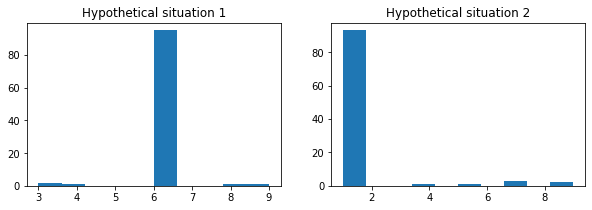

In [4]:
#create a state_values dictionary
states_and_values = {(1): 0.1, (1, 5): 0.9, (2):5, (2, 3, 1): 7, (2, 3, 9): 4, (1, 6): 3} 

#choose_move(avail_moves, current_state, states_and_values, epsilon = 0.1):

#hypothetical situation 1 
current_state = [1]
avail_moves = [2, 3, 4, 5, 6, 7, 8, 9]

#run 100 its
move1 = []
for i in range(100):
    move1.append(choose_move(avail_moves, current_state, states_and_values))
    
#situation 2
current_state = [2, 3]
avail_moves = [1, 4, 5, 6, 7, 8, 9]

#run 100 its 
move2 = []
for i in range(100):
    move2.append(choose_move(avail_moves, current_state, states_and_values))
    
#plot histograms to see which move was selected
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].hist(move1)
ax[1].hist(move2)
ax[0].set_title('Hypothetical situation 1')
ax[1].set_title('Hypothetical situation 2')
plt.show()

As expected the agent has selected move 6 in scenario 1 and move 1 in scenario 2. So the function seems to collect the moves correctly. 

Now let's create a function that rewards for winning states and penalizes losing states.

In [5]:
#function to give the rewards

def give_reward(states_and_values, states, reward, alpha, gamma):
    
    """
    inputs
    ---------
    states_and_values - a dictionary containing states and each state's values
    states - states at the end of the current game
    reward - the awarded reward or penalty value 
    alpha - the learning_rate by default set to 0.5
    gamma - the discount factor when giving rewards to earlier states. Default is 0.1
    
    output
    -------
    states_and_values - a dictionary after the moves with the new reward added
    """
    for state in reversed(states):
        
        if tuple(state) in states_and_values.keys():
            
            states_and_values[tuple(state)] += alpha * (gamma * reward - states_and_values[tuple(state)])
        
        else:         
            
            states_and_values[tuple(state)] = alpha * gamma * reward
        
        reward = states_and_values[tuple(state)]
        
    return states_and_values

<u> Create functions for self play and plot results</u>

In [6]:
def self_play(num_its, strategy_p1, strategy_p2, epsilon_p1 = 0.1, epsilon_p2 = 0.1, alpha_p1 = 0.2, alpha_p2 = 0.2, \
              gamma_p1 = 0.9, gamma_p2 = 0.9, print_game = False):
    
    """
    inputs
    -------
    num_its = number of iterations
    strategy_p1 = strategy of player 1. The strategy is either "random" or "rl" for both players
    strategy_p2 = strategy of player 2. The strategy is either "random" or "rl" for both players
    epsilon_p1 = exploration rate for player 1
    epsilon_p2 = exploration rate for player 2
    alpha_p1 = learning rate of player 1
    alpha_p2 = learning rate of player 2
    gamma_p1 = discount factor for player 1
    gamma_p2 = discount factor for player 2
    print_game = print every 1000 games true or false
    
    Outputs
    -------
    p1_wins = a vector containing 1 for wins and 0 for losses & draws for player 1
    p2_wins = a vector containing 1 for wins and 0 for losses & draws for player 2
    draw - a vector containing 1 for a draw game and 0 if a player won
    player1 = states and values for player 1
    player2 = states and values for player 2  
    
    """
        
    #player 1 memory NEWWWWWW
    player1 = {}
    p1_wins = []

    #p2
    player2 = {}
    p2_wins = []

    #draws
    draw = []

    for i in range(num_its):

        #player 1 is always first
        player = 1

        #game_on
        game_on = True

        #initialize the game
        game = tick_tack_toe()

        #intial values
        move_number = 1
        avail_moves = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        current_state = []
        winner = ''

        #lists
        states1 = []
        states2 = []

        while move_number < 10:


            #if a winner is declared by the game.check_winner() the game will stop and will assign the rewards
            if (winner == 'X') or (winner == 'O'):

                #print the end game after every 2000th iteration
                if ((i+1) % 5000 == 0) and (print_game == True):
                    
                    print('Game number {}\n'.format(i + 1))
                    game.print_board()


                break

            #choose move for each player

            if player == 1:
                
                if strategy_p1 == 'rl':
                    move = choose_move(avail_moves, current_state, player1, epsilon_p1)
                elif strategy_p1 == 'random':
                    move = np.random.choice(avail_moves)
                    
            elif player == 2:
                
                if strategy_p2 == 'rl':
                    move = choose_move(avail_moves, current_state, player2, epsilon_p2)
                elif strategy_p2 == 'random':
                    move = np.random.choice(avail_moves)
                    
            #play the move
            _, avail_moves = game.play(move, player)
            winner = game.check_winner()

            #change the move number
            move_number = move_number + 1
            #append the move to the current state
            current_state.append(move)

            #append all moves
            states1.append(list(current_state))
            states2.append(list(current_state))

            #switch turns
            if player == 1:

                player = 2

            elif player == 2:
                player = 1

        if winner == 'O':

            #player 1
            player1 = give_reward(player1, states1, 1, alpha_p1, gamma_p1)        

            #player 2
            player2 = give_reward(player2, states2, -1, alpha_p2, gamma_p2)

            p1_wins.append(1)
            p2_wins.append(0)
            draw.append(0)

        elif winner == 'X':

            #Player 2
            player2 = give_reward(player2, states2, 1, alpha_p2, gamma_p2)

            #player 1
            player1 = give_reward(player1, states1, -1, alpha_p1, gamma_p1)

            p1_wins.append(0)
            p2_wins.append(1)
            draw.append(0)


        elif winner is None:

            #player 1
            player1 = give_reward(player1, states1, 0.5, alpha_p1, gamma_p1)

            #player 2
            player2 = give_reward(player2, states2, 0.5, alpha_p2, gamma_p2)


            p1_wins.append(0)
            p2_wins.append(0)
            draw.append(1)
            
    return p1_wins, p2_wins, draw, player1, player2

#plot game and number of wins
def cum_sum(p_wins):
    """
    input
    ------
    p_wins - vector containing 1's and 0's
    
    output
    ------
    x + 1 - an array that represent each game
    y - cumulative sum at each x value
    
    """
    
    x = np.arange(0, len(p_wins))
    y = []
    s = 0
    
    for i in range(len(x)):
        
        s += p_wins[i]
        y.append(s)
        
    
    y = np.array(y)           
    
    return x + 1, y 

**Random Agent vs Random Agent**

Now Let's try to create a self play algorithm where two agents are playing together. Both agents are playing randomly chosen moves. Let's run 10,000 iterations and also also print 2 games.

In [7]:
p1_wins, p2_wins, draw, player1, player2 = self_play(10**4, 'random', 'random', print_game = True)

Game number 10000

    |    |   
 O  | O  | O
____|____|___
    |    |  
 X  | O  |  
____|____|___
    |    |  
 X  | X  |  
    |    |  


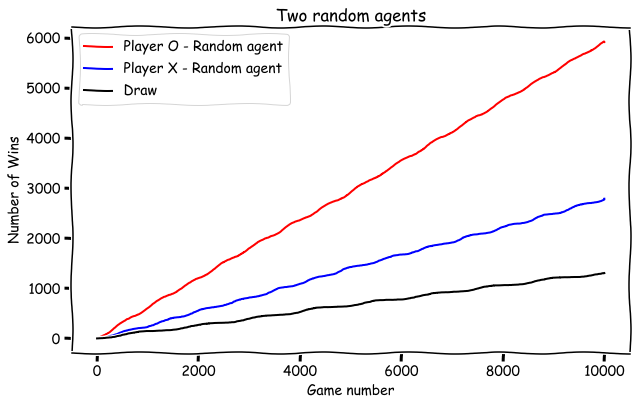

Winning percentage for player 1 (Random agent): 59.11 %
Winning percentage for player 2 (Random agent):  27.86 %
Percentage of a game being draw:  13.03 %


In [8]:
#plot the results

#for player 1 and 2 find the cumulative sum 

x1, y1 = cum_sum(p1_wins)
x2, y2 = cum_sum(p2_wins)
dx, dy = cum_sum(draw)

plt.figure(figsize = (10, 6))
plt.xkcd()
plt.plot(x1, y1, color = 'r', linewidth = 2, label = 'Player O - Random agent')
plt.plot(x2, y2, color = 'b', linewidth = 2, label = 'Player X - Random agent')
plt.plot(dx, dy, color = 'k', linewidth = 2, label = 'Draw')
plt.title('Two random agents')
plt.xlabel('Game number')
plt.ylabel('Number of Wins')
plt.legend()
plt.show()

#print winning percentage 
print('Winning percentage for player 1 (Random agent): {} %'.format(np.round(sum(p1_wins)/len(p1_wins)*100, 4)))
print('Winning percentage for player 2 (Random agent): ', np.round(sum(p2_wins)/len(p2_wins)*100, 4), '%')
print('Percentage of a game being draw: ', np.round(sum(draw)/len(draw)*100, 4), '%')

Player O, who starts first, has a clear advantage in this situation. As we can see when two random agents play the player1 wins about 59% of the time. Player 2 wins about 29% of the time.

**Reinforcement Learning Agent vs Random Agent**

In this scenario, let's let Player O (player who plays first) be a RL agent and the second player be a random agent. We will use the exploration rate, learning rate and discount the default values for the RL agent. (0.1, 0.2 and 0.9 respectively)

In [9]:
p1_wins, p2_wins, draw, player1, player2 = self_play(10**4, 'rl', 'random', print_game = True)

Game number 5000

    |    |   
 O  | O  | X
____|____|___
    |    |  
 X  | X  | O
____|____|___
    |    |  
 X  | O  |  
    |    |  


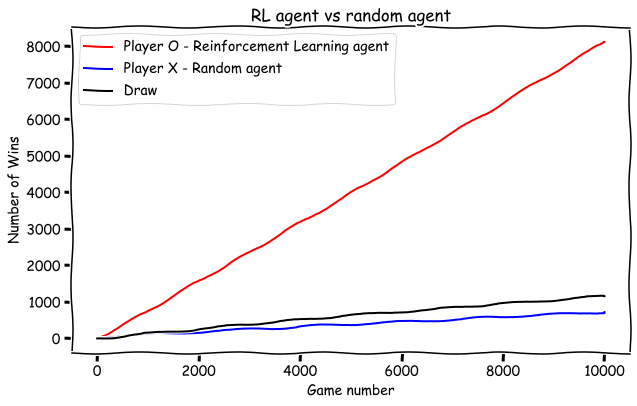

Winning percentage for player 1 (RL agent): 81.21 %
Winning percentage for player 2 (Random agent):  7.22 %
Percentage of a game being draw:  11.57 %


In [10]:
#plot the results

#for player 1 and 2 find the cumulative sum 

x1, y1 = cum_sum(p1_wins)
x2, y2 = cum_sum(p2_wins)
dx, dy = cum_sum(draw)

plt.figure(figsize = (10, 6))
plt.xkcd()
plt.plot(x1, y1, color = 'r', linewidth = 2, label = 'Player O - Reinforcement Learning agent')
plt.plot(x2, y2, color = 'b', linewidth = 2, label = 'Player X - Random agent')
plt.plot(dx, dy, color = 'k', linewidth = 2, label = 'Draw')
plt.title('RL agent vs random agent')
plt.xlabel('Game number')
plt.ylabel('Number of Wins')
plt.legend()
plt.show()

#print winning percentage 
print('Winning percentage for player 1 (RL agent): {} %'.format(np.round(sum(p1_wins)/len(p1_wins)*100, 4)))
print('Winning percentage for player 2 (Random agent): ', np.round(sum(p2_wins)/len(p2_wins)*100, 4), '%')
print('Percentage of a game being draw: ', np.round(sum(draw)/len(draw)*100, 4), '%')

Let's also plot the reward distrubution of the RL agent.

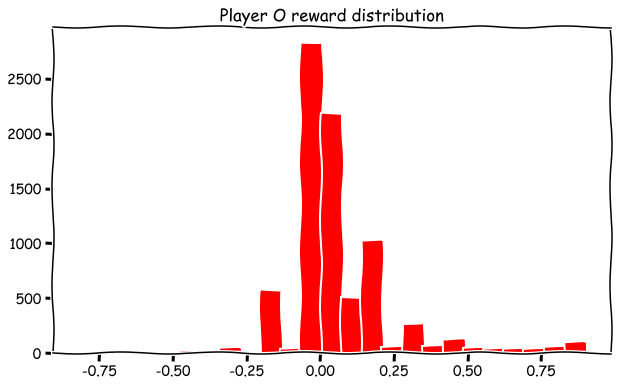

In [11]:
plt.figure(figsize = (10, 6))
plt.xkcd()
plt.hist(player1.values(), bins = 25, label = 'Player O', color = 'r')
plt.title('Player O reward distribution')
plt.show()

The RL agent is winning clearly in this situation. Out of 10,000 games the RL agent has won 89 percent of the time. The random agent in this case has only won 5.74% of the time. So the learning agent has a clear advantage over the random agent.

**Random agent vs Reinforcement Learning Agent**

Now lets let the random agent play first and the RL agent play second. Given the advantage of playing first the random agent should have a slighly higher advantage than the previous simulations. And also in this scenario we could expect a higher percentage of games drawn since the RL agent will try to avoid losing.

In [12]:
p1_wins, p2_wins, draw, player1, player2 = self_play(10**4, 'random', 'rl', print_game = True)

Game number 5000

    |    |   
 O  | O  |  
____|____|___
    |    |  
 X  | O  | X
____|____|___
    |    |  
    | O  | X
    |    |  
Game number 10000

    |    |   
 X  | O  | O
____|____|___
    |    |  
 O  | X  |  
____|____|___
    |    |  
    |    | X
    |    |  


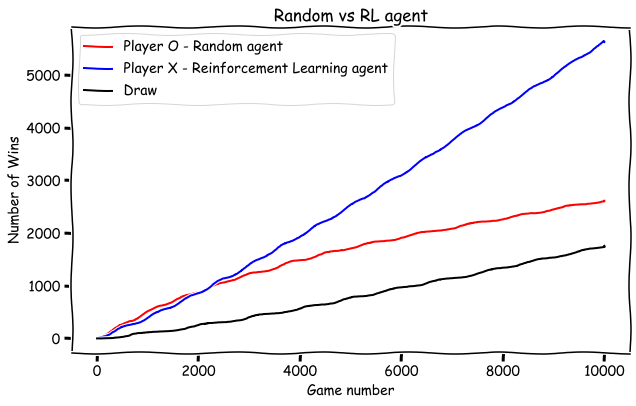

Winning percentage for player 1 (Random agent): 26.14 %
Winning percentage for player 2 (RL agent):  56.28 %
Percentage of a game being draw:  17.58 %


In [13]:
#plot the results

#for player 1 and 2 find the cumulative sum 

x1, y1 = cum_sum(p1_wins)
x2, y2 = cum_sum(p2_wins)
dx, dy = cum_sum(draw)

plt.figure(figsize = (10, 6))
plt.xkcd()
plt.plot(x1, y1, color = 'r', linewidth = 2, label = 'Player O - Random agent')
plt.plot(x2, y2, color = 'b', linewidth = 2, label = 'Player X - Reinforcement Learning agent')
plt.plot(dx, dy, color = 'k', linewidth = 2, label = 'Draw')
plt.title('Random vs RL agent')
plt.xlabel('Game number')
plt.ylabel('Number of Wins')
plt.legend()
plt.show()

#print winning percentage 
print('Winning percentage for player 1 (Random agent): {} %'.format(np.round(sum(p1_wins)/len(p1_wins)*100, 4)))
print('Winning percentage for player 2 (RL agent): ', np.round(sum(p2_wins)/len(p2_wins)*100, 4), '%')
print('Percentage of a game being draw: ', np.round(sum(draw)/len(draw)*100, 4), '%')

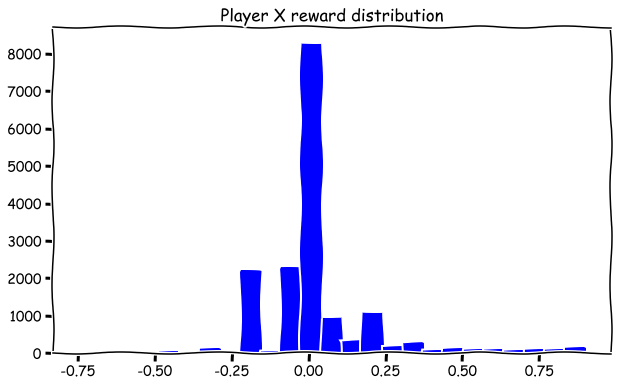

In [14]:
plt.figure(figsize = (10, 6))
plt.xkcd()
plt.hist(player2.values(), bins = 25, label = 'Player X', color = 'b')
plt.title('Player X reward distribution')
plt.show()

In this case like we expected the RL agent has a lower winning percentage because the player is starting second. The random agent takes advantage of playing first at the begining and the RL agent becomes better and better with more experience (more games). Like we expected the draw percentage has increased dramatically (from 5% to 14%). We can see clearly that the RL agent has learnt to draw games. 

**RL agent vs RL agent**

Finally let's check what happens when an RL agent plays with an RL agent. We could expect that the RL agent who plays first will have the advantage over the second player. 

In [15]:
p1_wins, p2_wins, draw, player1, player2 = self_play(10**4, 'rl', 'rl', print_game = True)

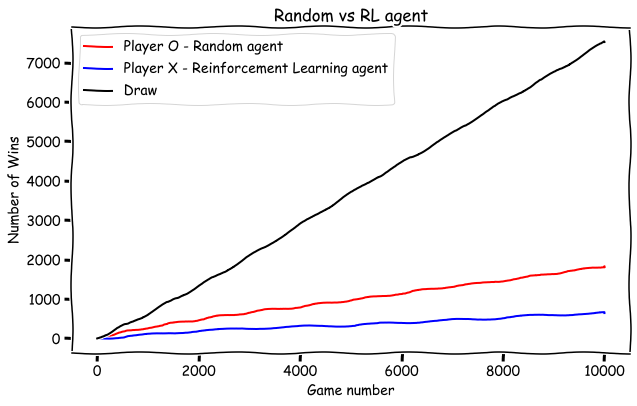

Winning percentage for player 1 (Random agent): 18.29 %
Winning percentage for player 2 (RL agent):  6.45 %
Percentage of a game being draw:  75.26 %


In [16]:
#plot the results

#for player 1 and 2 find the cumulative sum 

x1, y1 = cum_sum(p1_wins)
x2, y2 = cum_sum(p2_wins)
dx, dy = cum_sum(draw)

plt.figure(figsize = (10, 6))
plt.xkcd()
plt.plot(x1, y1, color = 'r', linewidth = 2, label = 'Player O - Random agent')
plt.plot(x2, y2, color = 'b', linewidth = 2, label = 'Player X - Reinforcement Learning agent')
plt.plot(dx, dy, color = 'k', linewidth = 2, label = 'Draw')
plt.title('Random vs RL agent')
plt.xlabel('Game number')
plt.ylabel('Number of Wins')
plt.legend()
plt.show()

#print winning percentage 
print('Winning percentage for player 1 (Random agent): {} %'.format(np.round(sum(p1_wins)/len(p1_wins)*100, 4)))
print('Winning percentage for player 2 (RL agent): ', np.round(sum(p2_wins)/len(p2_wins)*100, 4), '%')
print('Percentage of a game being draw: ', np.round(sum(draw)/len(draw)*100, 4), '%')

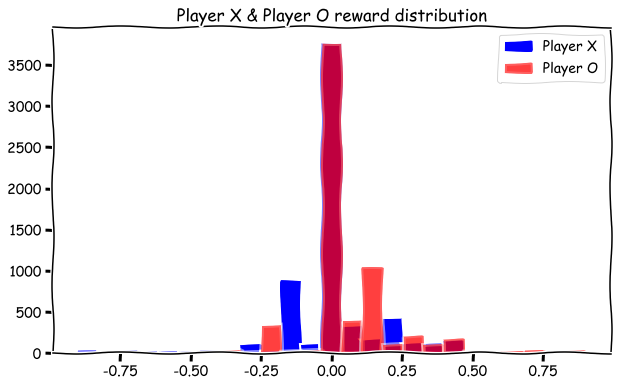

In [17]:
plt.figure(figsize = (10, 6))
plt.xkcd()
plt.hist(player2.values(), bins = 25, label = 'Player X', color = 'b')
plt.hist(player1.values(), bins = 25, label = 'Player O', color = 'r', alpha = 0.5)
plt.title('Player X & Player O reward distribution')
plt.legend()
plt.show()

As expected in this scenario the player 1 has an advantage of playing first but the player 2 has learnt to draw games and because of this we see a lot of drawn games. The draw percentage in this case is almost 80%. So both players have learnt to play tick tack toe.